In [1]:
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
from pynestml.frontend.pynestml_frontend import generate_nest_target


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jul 13 2025 01:06:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def generate_code(neuron_model: str, models_path=""):
    """
    Generate NEST code for neuron model with gap junction support.
    Parameters
    ----------
    neuron_model : str
        Name of the neuron model to compile. This should correspond to a 
        .nestml file containing the neuron model definition.
    models_path : str, optional
        Path to the directory containing the NESTML model files.
        Default is empty string (current directory).
    """
    codegen_opts = {"gap_junctions": {"enable": True,
                                        "gap_current_port": "I_stim",
                                        "membrane_potential_variable": "V_m"}}

    files = os.path.join(models_path, neuron_model + ".nestml")
    generate_nest_target(input_path=files,
                            logging_level="WARNING",
                            module_name="nestml_gap_" + neuron_model + "_module",
                            suffix="_nestml",
                            codegen_opts=codegen_opts)

    return neuron_model

In [3]:
def initialize_hh():
    nest.Install("nestml_gap_hh_psc_alpha_neuron_module")
    neurons = nest.Create("hh_psc_alpha_neuron_nestml", 4)
    neurons.I_e = 20.0
    neurons[0].V_m = -60.0
    neurons[2].V_m = -60.0

    return neurons

In [4]:
def initialize_aeif():
    nest.Install("nestml_gap_aeif_cond_exp_neuron_module")
    neurons = nest.Create("aeif_cond_exp_neuron_nestml", 4)
    neurons.I_e = 20
    neurons[0].V_m = -60.0 
    neurons[2].V_m = -60.0 

    return neurons

In [5]:
def initilize_eglif():
    nest.Install("nestml_gap_eglif_multirec_opt_module")
    neurons = nest.Create("eglif_multirec_opt_nestml", 4)
    neurons.set({
        "V_m": -45,
        "E_L": -45,
        "C_m": 189,
        "tau_m": 11,
        "I_e": -18.101,
        "k_adap": 1.928,
        "k_1": 0.191,
        "k_2": 0.090909,
        "V_th": -35,
        })
    neurons[0].V_m = -46.0 
    neurons[2].V_m = -46.0 

    return neurons

In [6]:
def initialize_cells(model):
    if model == "hh":
        return initialize_hh()
    elif model == "aeif":
        return initialize_aeif()
    elif model == "eglif":
        return initilize_eglif()
        

In [7]:
def plot_vm(vm):
    vm_values = vm.events["V_m"]
    senders = vm.events["senders"]
    times = vm.events["times"]
    plt.figure(figsize=(10, 5))
    for cell_num in np.unique(vm.events["senders"]):
        plt.plot(
            times[np.where(senders == cell_num)], vm_values[np.where(senders == cell_num)],label=f"Neuron {cell_num}")
    plt.legend(loc='upper right')
    plt.xlabel("time (ms)")
    plt.ylabel("membrane potential (mV)")
    plt.savefig("output.png")
    plt.show()

In [8]:
def plot_mm_stim(mm_stim):
    I_stim_values = mm_stim.events["I_stim_recordable"]
    senders_Istim = mm_stim.events["senders"]
    times_Istim = mm_stim.events["times"]

    plt.figure(figsize=(10, 5))
    for cell_num in np.unique(mm_stim.events["senders"]):
        plt.plot(
        times_Istim[np.where(senders_Istim == cell_num)], I_stim_values[np.where(senders_Istim == cell_num)],label=f"Neuron {cell_num}"
    )

    plt.legend(loc="upper right")
    plt.xlabel("time (ms)")
    plt.ylabel("I_stim (pA)")
    plt.title("I stim current")
    plt.show()

In [9]:
def plot_sr(sr, simulation_time=1000.0):
    evs = sr.events["senders"]
    ts = sr.events["times"]
    
    # Calculate firing rates for each neuron
    unique_neurons = np.unique(evs)
    firing_rates = {}
    
    for neuron_id in unique_neurons:
        spike_count = np.sum(evs == neuron_id)
        firing_rate = spike_count / (simulation_time / 1000.0)  # Convert ms to seconds
        firing_rates[neuron_id] = firing_rate

    # Create firing rate string for title
    rate_strings = [f"N{nid}: {rate:.1f}Hz" for nid, rate in firing_rates.items()]
    rate_title = " | ".join(rate_strings)
    
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    plt.figure(figsize=(10, 5))
    
    # Plot each neuron with its specific color
    for neuron_id in unique_neurons:
        neuron_mask = evs == neuron_id
        color_idx = neuron_id - 1 if neuron_id <= len(colors) else 0  # Use neuron_id-1 as color index
        plt.plot(ts[neuron_mask], evs[neuron_mask], ".", 
                color=colors[color_idx], label=f"Neuron {neuron_id}")
    
    plt.xlabel("time (ms)")
    plt.ylabel("neuron ID")
    plt.ylim(0.5, 4.5)
    plt.yticks([1, 2, 3, 4])
    plt.title(f"Spike raster plot\n{rate_title}")
    plt.legend()
    plt.show()
    
    return firing_rates

In [10]:
def simulate_network(selected_model, dc_stim=False, dc_neurons="first", dc_amplitude=10):
    nest.ResetKernel()
    nest.resolution = 0.05

    neurons = initialize_cells(selected_model)

    # Voltmeter connected to all neurons
    vm = nest.Create("voltmeter", params={"interval": 0.1})
    nest.Connect(vm, neurons, "all_to_all")

    sr = nest.Create("spike_recorder")
    nest.Connect(neurons, sr)

    # Optional DC stimulation
    if dc_stim:
        dc = nest.Create("dc_generator", params={"amplitude":dc_amplitude})
        if dc_neurons == "first":
            nest.Connect(dc, neurons[0], syn_spec={"weight": 1.0})
            nest.Connect(dc, neurons[2], syn_spec={"weight": 1.0})
        elif dc_neurons == "all":
            nest.Connect(dc, neurons, syn_spec={"weight": 1.0})

        
    
    # Create a multimeter for I_stim_recordable if present
    I_stim_recordable ="I_stim_recordable" in nest.GetDefaults(models.get(selected_model))["recordables"]
    if I_stim_recordable:
        mm_stim = nest.Create("multimeter", {"record_from": ["I_stim_recordable"] })
        nest.Connect(mm_stim, neurons)

    # Connect neurons 1 and 2
    nest.Connect(
            neurons[0], neurons[1], 
            {"rule": "one_to_one", "allow_autapses": False,"make_symmetric":True}, 
            {"synapse_model": "gap_junction", "weight": 100}
        )

    # Simulation
    simulation_time = 1000.0
    nest.Simulate(simulation_time)

    # Plots
    plot_vm(vm)
    if I_stim_recordable:
        plot_mm_stim(mm_stim)
    if len(sr.events["times"]) > 0:
        plot_sr(sr, simulation_time)

    # V_m analysis
    vm_values = vm.events["V_m"]
    senders = vm.events["senders"]
    vm_per_cell = {}
    for cell_num in np.unique(vm.events["senders"]):
        vm_per_cell[cell_num] = vm_values[np.where(senders == cell_num)]

    print(f"V_m of cell 1 and cell 3 are equal: {np.allclose(vm_per_cell[1], vm_per_cell[3], atol=1e-9)}")
    print(f"V_m of cell 2 and cell 4 are equal: {np.allclose(vm_per_cell[2], vm_per_cell[4], atol=1e-9)}")

    
    


Oct 15 16:30:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.05 ms.

Oct 15 16:30:26 Install [Info]: 
    loaded module nestml_gap_eglif_multirec_opt_module

Oct 15 16:30:26 NodeManager::prepare_nodes [Info]: 
    Preparing 6 nodes for simulation.

Oct 15 16:30:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Oct 15 16:30:26 SimulationManager::run [Info]: 
    Simulation finished.


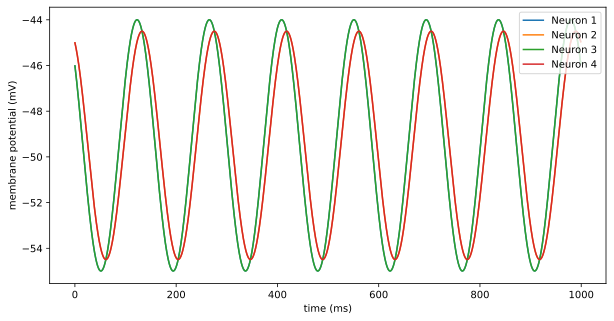

V_m of cell 1 and cell 3 are equal: True
V_m of cell 2 and cell 4 are equal: True


In [11]:
filenames = {
    "hh": "hh_psc_alpha_neuron",
    "eglif": "eglif_multirec_opt",
    "aeif": "aeif_cond_exp_neuron", 
}
models = {
    "hh": "hh_psc_alpha_neuron_nestml",
    "aeif": "aeif_cond_exp_neuron_nestml", 
    "eglif": "eglif_multirec_opt_nestml"
}
selected_model = "eglif"
generate_model = False

if generate_model:
    generate_code(neuron_model=filenames[selected_model], models_path="../nest_models")

simulate_network(selected_model)